# GeoCluster 1st hierarchy

Load required libraries and initiate basic objects.

In [1]:
# External libraries.
import torch
import numpy as np
import matplotlib.pyplot as plt
# Internal libraries.
from src.utils.data import loadData
from src import visualization as vis
from src.utils import plot_tools as pt

Loading data...
Data loaded.
[100.         290.           1.           0.35545887]


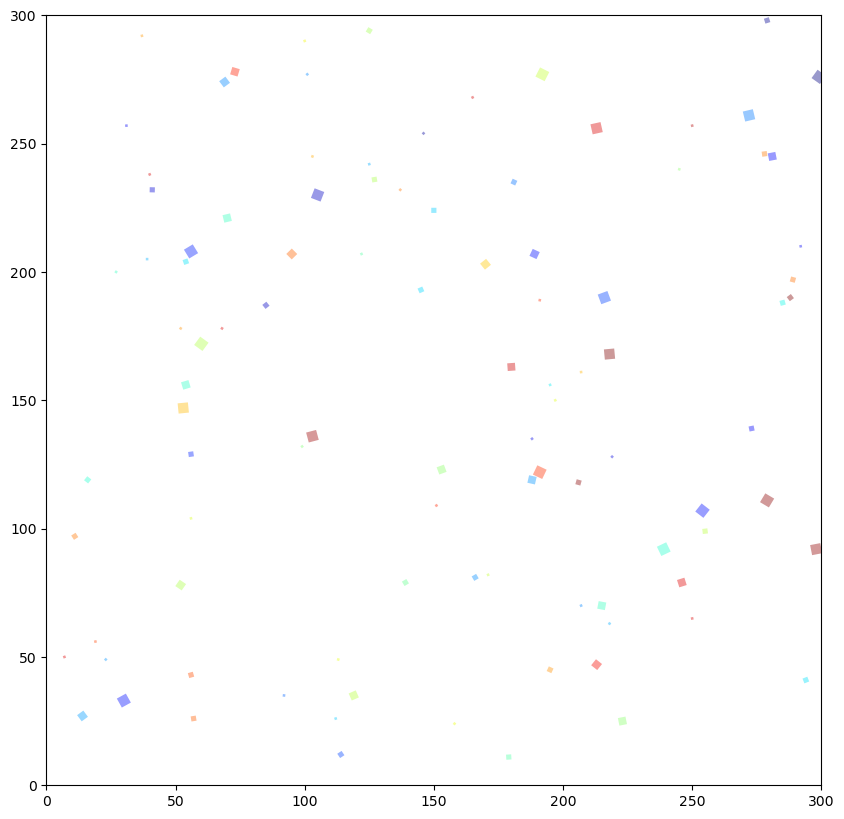

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Load data.
squares, _ = loadData(100)
print(squares[0])
vis.plot_data(squares, limits=[0, 300, 0, 300])

## Training Teacher

In [3]:
from src.models import LVGEBM

teacher = LVGEBM(4, 2, 400).to(device)
learning_rate = 1e-2
teacher.train_(optimizer=torch.optim.Adam(teacher.parameters(), lr=learning_rate),
               epochs=200,
               times=10,
               train_data=torch.from_numpy(squares).float().to(device),
               alpha=5,
               beta=10)

# Save best model state to .pt format.
torch.save(teacher.best_model_state, "models/squares/100/teacher_config.pt")
print("Saved teacher config to models/squares/100/teacher_config.pt")

# Save training results to .npy format.
teacher_results = {
    "best_model_state": teacher.best_model_state,
    "best_outputs": teacher.best_outputs,
    "best_z": teacher.best_z,
    "best_lat": teacher.best_lat,
    "best_epoch": teacher.best_epoch,
    "p_p": teacher.p_p,
    "p_c": teacher.p_c,
    "reg_proj_array": teacher.reg_proj_array,
    "reg_latent_array": teacher.reg_latent_array,
    "memory": teacher.memory,
    "cost_array": teacher.cost_array
}
np.save("models/squares/100/teacher_training_results.npy", teacher_results)
print("Saved teacher training results to models/squares/100/teacher_training_results.npy")

Training Teacher Model
Epoch: 20/200..  Training loss: 11623.74707..  Reg Proj: 0.00000..  Reg Latent: 0.28193..  Memory: 11620.92773..  Cost: 11623.74707.. 
Epoch: 40/200..  Training loss: 7754.02979..  Reg Proj: 0.00000..  Reg Latent: 0.41373..  Memory: 7749.89258..  Cost: 7754.02979.. 
Epoch: 60/200..  Training loss: 8602.22656..  Reg Proj: 0.00000..  Reg Latent: 2.12334..  Memory: 8580.99316..  Cost: 8602.22656.. 
Epoch: 80/200..  Training loss: 7532.08203..  Reg Proj: 0.00000..  Reg Latent: 0.94136..  Memory: 7522.66846..  Cost: 7532.08203.. 
Epoch: 100/200..  Training loss: 7142.73047..  Reg Proj: 0.00000..  Reg Latent: 0.24698..  Memory: 7140.26074..  Cost: 7142.73047.. 
Epoch: 120/200..  Training loss: 7505.15869..  Reg Proj: 0.00000..  Reg Latent: 0.26858..  Memory: 7502.47266..  Cost: 7505.15869.. 
Epoch: 140/200..  Training loss: 6961.32812..  Reg Proj: 0.00000..  Reg Latent: 0.20687..  Memory: 6959.25928..  Cost: 6961.32812.. 
Epoch: 160/200..  Training loss: 8232.37402..  

In [4]:
# Load model from configuration (no need to train each time).
# WARNING: Training results in model object will be reset, run next cell to reload.
from src.models import LVGEBM
teacher = LVGEBM(4, 2, 400).to(device)
teacher.load_state_dict(torch.load("models/squares/100/teacher_config.pt"))
teacher.eval()
print("Loaded teacher config from models/squares/100/teacher_config.pt")

Loaded teacher config from models/squares/100/teacher_config.pt


In [5]:
# Load the training results (optional in general, necessary for following cells).
teacher_results = np.load("models/squares/100/teacher_training_results.npy", allow_pickle=True).item()
for name, value in teacher_results.items():
    setattr(teacher, name, value)
print("Loaded teacher training results from models/squares/100/teacher_training_results.pt")

Loaded teacher training results from models/squares/100/teacher_training_results.pt


Load and print some important variables.

In [6]:
print("best epoch: ", teacher.best_epoch)
print("best outputs: ", teacher.best_outputs)
# print("costs: ", teacher.cost_array)

best epoch:  190
best outputs:  tensor([[230.2174, 136.3419],
        [ 52.4591, 192.6295],
        [252.5279, 252.8550],
        [ 75.5504,  49.8538]], requires_grad=True)


Plot results

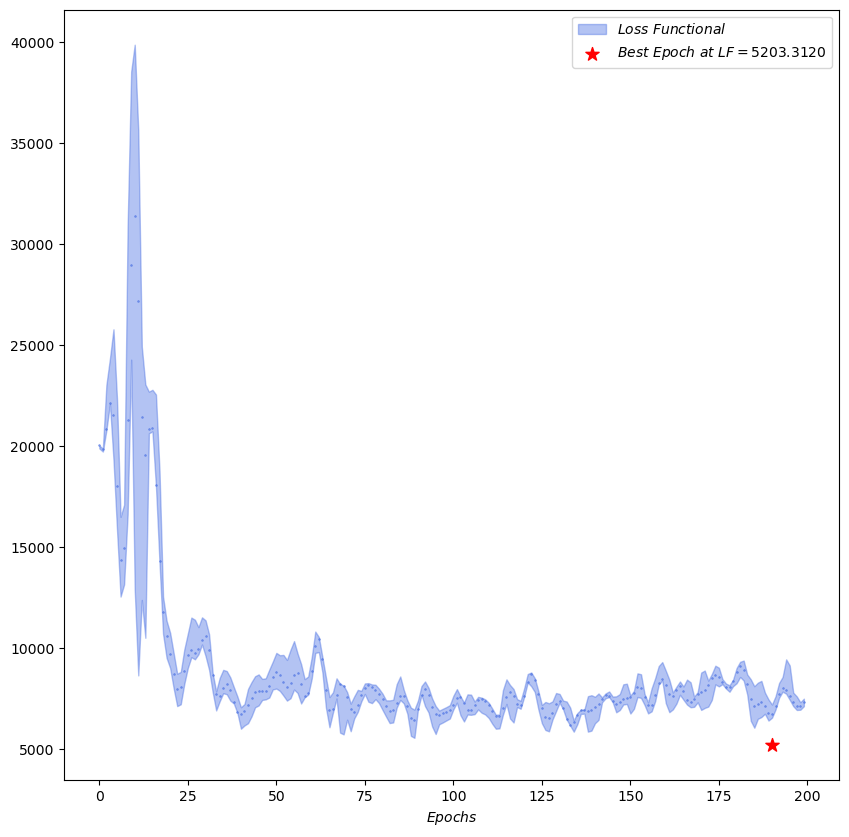

In [7]:
# Plot the Amplitude demodulation of the signal (costs array).
signal = teacher.cost_array
upper_signal, lower_signal, filtered_signal = pt.AM_dem(signal, fc=0.4*len(signal), fs=2*len(signal))
pt.plot_AM_dem(upper_signal, lower_signal, filtered_signal, signal, teacher.best_epoch)

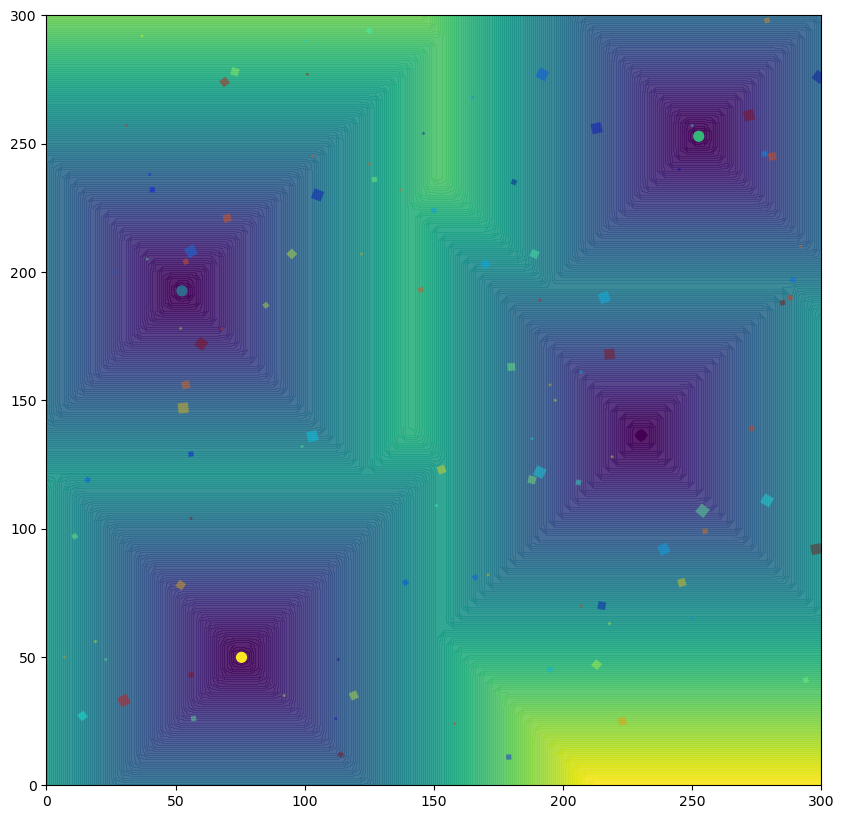

In [8]:
# Plot the best model with the best outputs.
manifold = pt.createManifold(teacher, teacher.best_outputs.cpu())
pt.plotManifold(squares, manifold, teacher.best_outputs.cpu(), [0, 300], [0, 300])

## Uncertainty Area

Predicting...
Processing...
flag is 6540
m is 3461
i is 10000
Points sampled:  3461


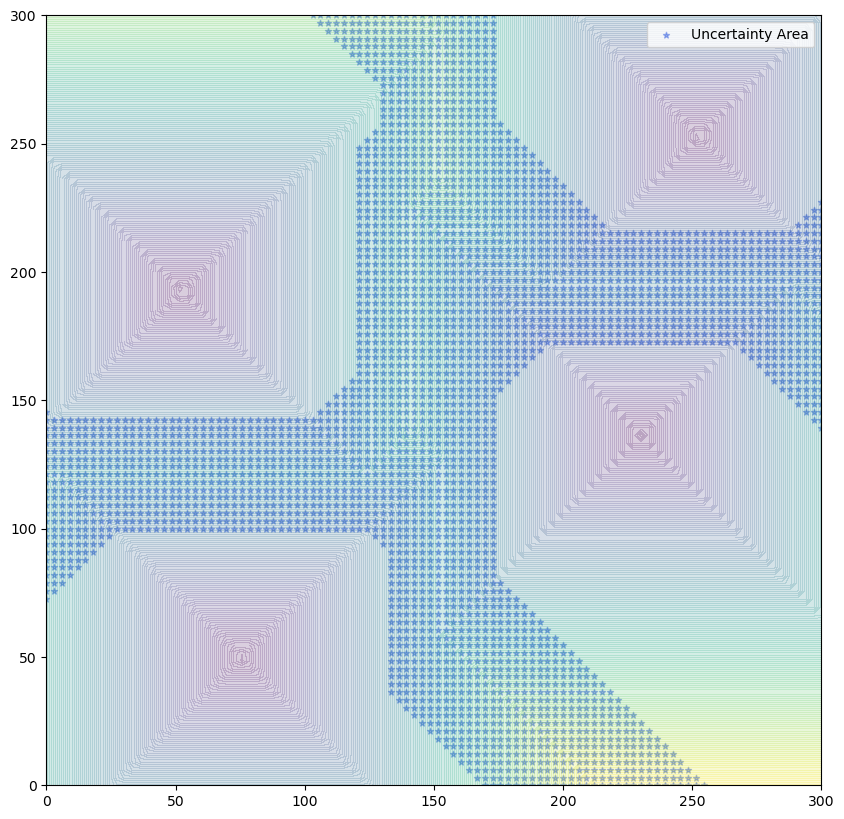

In [9]:
from src.utils.functions import getUncertaintyArea

sensitivity = 0.15
print('Predicting...')
m_points = getUncertaintyArea(teacher.best_outputs.cpu().detach().numpy(),
                              N=100,
                              M=10000-1,
                              epsilon=sensitivity,
                              x_area=[0,300],
                              y_area=[0,300],
                              model=teacher)
print('Points sampled: ', len(m_points))

# Plot the m points that are in the uncertainty area.
m_points = np.array(m_points)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(m_points[:, 0], m_points[:, 1], s=20, c='royalblue', alpha=0.5, marker='*', label='Uncertainty Area')
ax.contourf(manifold[:, :, 0], manifold[:, :, 1], manifold[:, :, 2], levels=200, cmap='viridis', alpha=0.2)
plt.legend()

## Labeling

In [10]:
from src.utils.functions import getE

qp = np.random.permutation(m_points)
qp = torch.tensor(qp)
F, z, F_sq, z_sq = getE(teacher, teacher.best_outputs.cpu(), qp, squares)

# Initialize the pseudo clusters.
# Append squares that their z_sq is i for each centroid.
pseudo_clusters = [squares[z_sq == i] for i in range(teacher.n_centroids)]

### Create Labels

In [11]:
from src.utils.functions import NearestNeighbour

outputs_shape = (qp.shape[0], teacher.n_centroids)
F_ps = torch.zeros(outputs_shape)
z_ps = torch.zeros(outputs_shape)
for i in range(outputs_shape[0]):
    if i % 1000 == 0:
        print(f"Labeled {i}/{outputs_shape[0]} points.")
    for j in range(outputs_shape[1]):
        qpoint = qp[i].cpu().detach().numpy()
        F_ps[i,j], z_ps[i,j] = torch.tensor(NearestNeighbour(qpoint, pseudo_clusters[j]))
print(f"Labeled all {outputs_shape[0]}/{outputs_shape[0]} points.")

Labeled 0/3461 points.
Labeled 1000/3461 points.
Labeled 2000/3461 points.
Labeled 3000/3461 points.
Labeled all 3461/3461 points.


### Plot labels

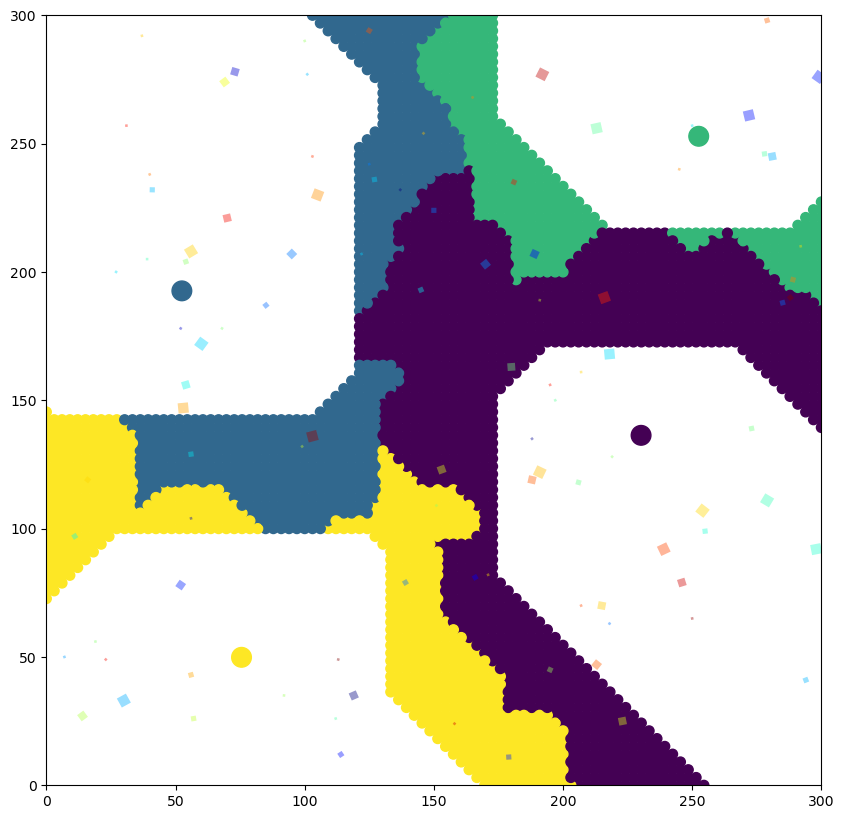

In [12]:
# plot qp
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
# labels are z
labels =  z
plt_qp = qp.cpu().detach().numpy()
new_labels = F_ps.min(1)[1].cpu().detach().numpy()
ax.scatter(plt_qp[:, 0], plt_qp[:, 1], c=new_labels, s=50)
# plot best_outputs
plt_bo = teacher.best_outputs.cpu().detach().numpy()
plt_bo = plt_bo
c = np.linspace(0, teacher.best_outputs.shape[0], teacher.best_outputs.shape[0])
ax.scatter(plt_bo[:, 0], plt_bo[:, 1], c=c, s=200)
z_labels = z
pt.plot_data_on_manifold(fig, ax, squares, size=10, limits=[0, 300, 0, 300])
# plot_data(fig,ax,sq, size=10, limits=[0,300,0,300])

## Training Student

In [13]:
from src.models import Voronoi

student = Voronoi(4, 2, 2).to(device) # initialize the voronoi network
epochs = 30000 # number of epochs
student.train_(optimizer=torch.optim.Adam(student.parameters(), lr=1e-3),
               epochs=epochs,
               device=device,
               qp=qp,
               F_ps=F_ps)

# Save voronoi model.
torch.save(student.best_vor_model_state, "models/squares/100/student_config.pt")
print("Saved student config to models/squares/100/student_config.pt")

# Save training results to .npy format.
student_results = {
    "best_vor_model_state": student.best_vor_model_state,
    "cost_ll": student.cost_ll,
    "acc_l": student.acc_l,
    "es": student.es
}
np.save("models/squares/100/student_training_results.npy", student_results)
print("Saved teacher training results to models/squares/100/student_training_results.npy")

Training Student Model
Acc:  0.12048540884137532
Epoch:  0 Cost:  1348.7542724609375
Acc:  0.9008956948858712
Epoch:  2000 Cost:  27.800613403320312
Acc:  0.9214099971106616
Epoch:  4000 Cost:  18.96160316467285
Acc:  0.9052297023981508
Epoch:  6000 Cost:  19.93973731994629
Acc:  0.9517480496966195
Epoch:  8000 Cost:  11.477410316467285
Acc:  0.9381681594914765
Epoch:  10000 Cost:  12.719051361083984
Acc:  0.9462583068477318
Epoch:  12000 Cost:  11.198418617248535
Acc:  0.9601271308870268
Epoch:  14000 Cost:  9.357314109802246
Acc:  0.9745738225946259
Epoch:  16000 Cost:  7.824484825134277
Acc:  0.9560820572088992
Epoch:  18000 Cost:  9.055427551269531
Acc:  0.9800635654435135
Epoch:  20000 Cost:  6.954108238220215
Acc:  0.9789078301069055
Epoch:  22000 Cost:  6.931153774261475
Acc:  0.9867090436290089
Epoch:  24000 Cost:  6.213451862335205
Acc:  0.9676394105749784
Epoch:  26000 Cost:  7.736966133117676
Acc:  0.9335452181450448
Epoch:  28000 Cost:  15.979698181152344
Saved student conf

In [14]:
# Load model from configuration (no need to train each time).
# WARNING: Training results in model object will be reset, run next cell to reload.
from src.models import Voronoi

student = Voronoi(4, 2, 2).to(device)
student.load_state_dict(torch.load("models/squares/100/student_config.pt"))
student.eval()
print("Loaded student config from models/squares/100/student_config.pt")

Loaded student config from models/squares/100/student_config.pt


In [15]:
# Load the training results (optional in general, necessary for following cells).
student_results = np.load("models/squares/100/student_training_results.npy", allow_pickle=True)
for name, value in student_results.item().items():
    setattr(student, name, value)
print("Loaded student training results from models/squares/100/student_training_results.pt")

Loaded student training results from models/squares/100/student_training_results.pt


Plot Accuracy and Loss

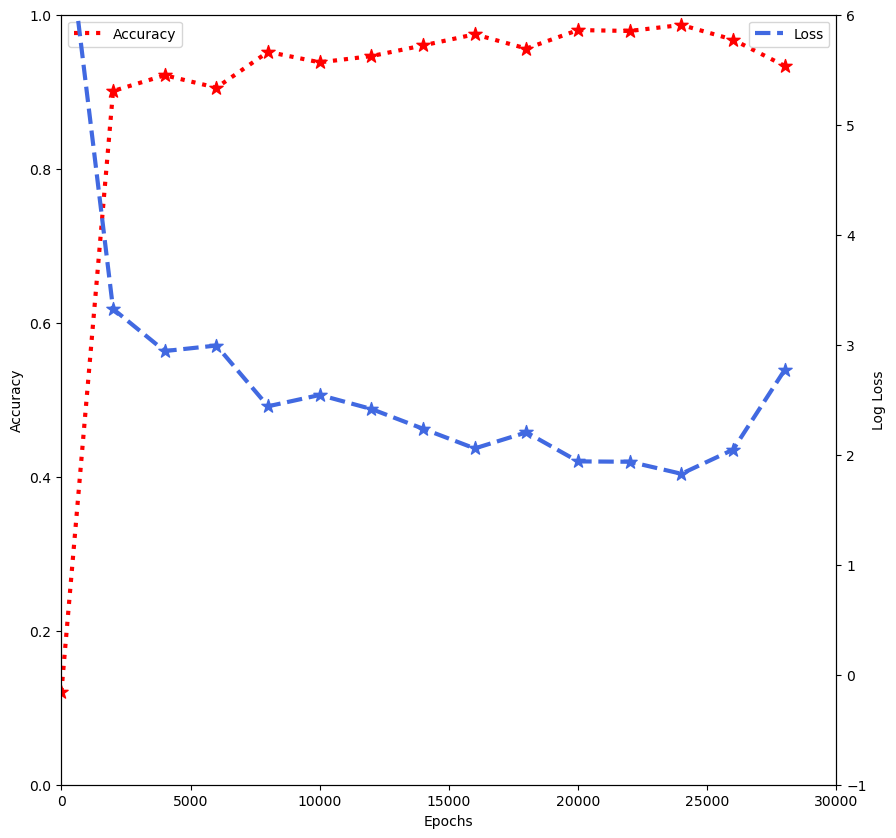

In [16]:
student.plot_accuracy_and_loss(epochs)

## Inferencing

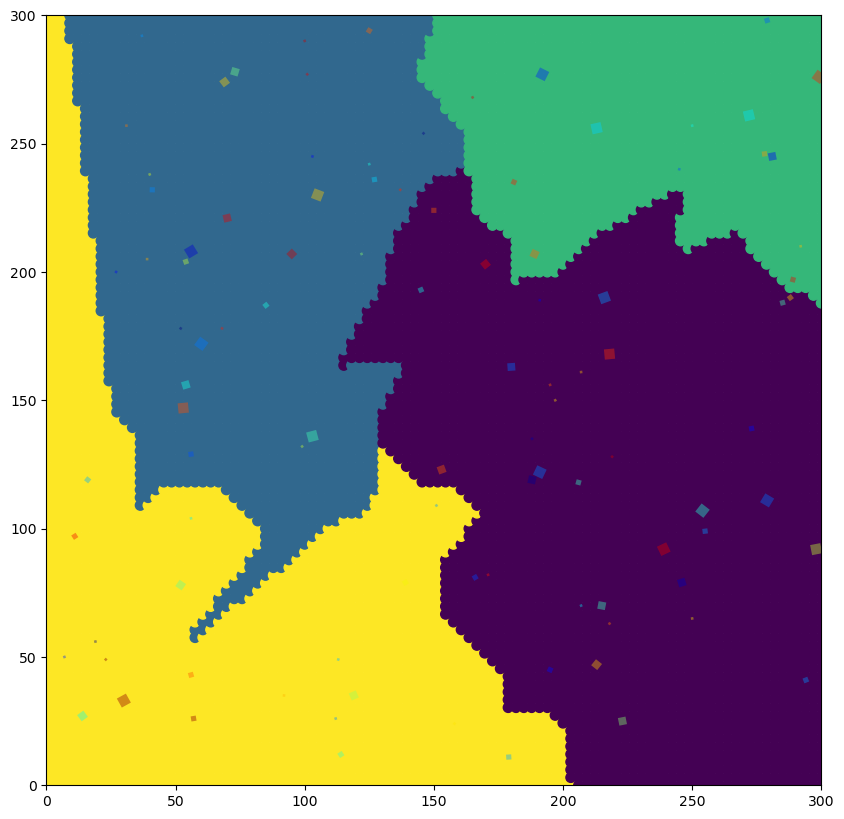

In [17]:
# ok lets infer
infer_points = torch.zeros(10000, 2) # initialize the infer points
x_lim = [0, 300] # x limits
y_lim = [0, 300] # y limits
for i, x in enumerate(np.linspace(x_lim[0], x_lim[1], 100)): # sample 100 points in x_lim
    for j, y in enumerate(np.linspace(y_lim[0], y_lim[1], 100)): # sample 100 points in y_lim
        infer_points[i * 100 + j] = torch.Tensor([x, y]) # append the point to infer_points

infer_points = infer_points.to(device) # send infer_points to device
classes = student(infer_points) # get the classes of infer_points
infer_points = infer_points.cpu().detach().numpy() # send infer_points to cpu
classes = classes.max(1)[-1].cpu().detach().numpy() # send classes to cpu

# Plot classes.
fig = plt.figure(figsize=(10, 10)) # initialize the figure
ax = fig.add_subplot(111) # add subplot
ax.scatter(infer_points[:, 0], infer_points[:, 1], c=classes, s=50) # plot infer_points
# plot scatter of output = model(model.z)
pt.plot_data_on_manifold(fig, ax, squares, size=10, limits=[0, 300, 0, 300]) # plot sq

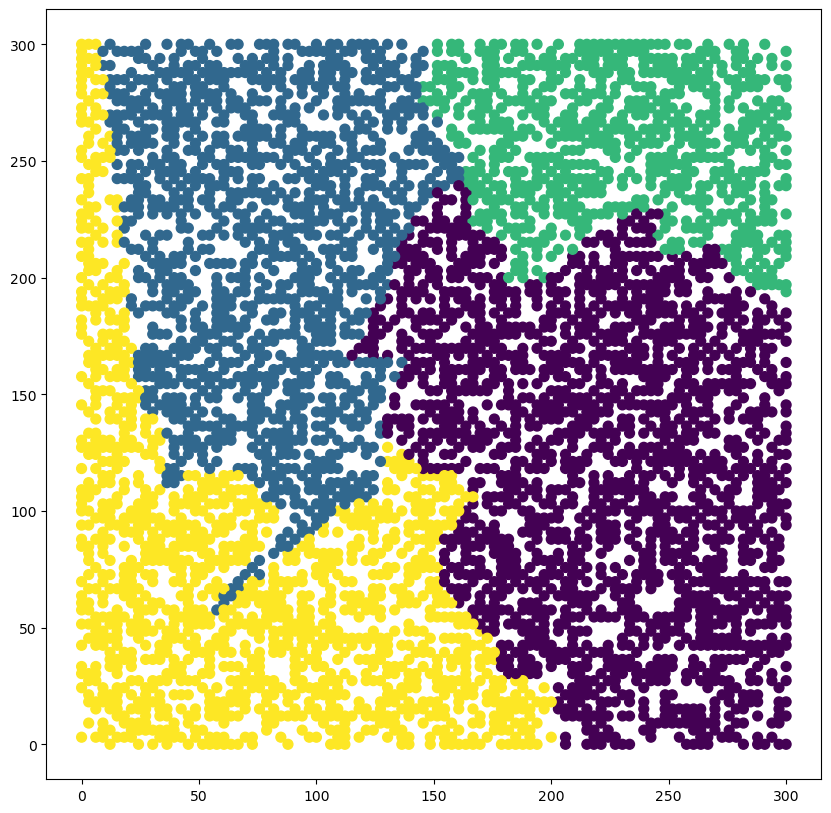

In [18]:
# Take 5000 randomly of those 10000 points randomly in [0,300]x[0,300].
infer_points = torch.from_numpy(infer_points)
infer_points = infer_points[torch.randperm(infer_points.shape[0])][:5000]
infer_points = infer_points.to(device)
classes = student(infer_points)
z = classes.max(1)[-1].cpu().detach().numpy()
infer_points = infer_points.cpu().detach().numpy()
# plot infer_points
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(infer_points[:, 0], infer_points[:, 1], c=z, s=50)

### Randomly inferred points.

In [19]:
outputs_shape = (infer_points.shape[0], teacher.n_centroids) # initialize outputs shape
F_ps_infer = torch.zeros(outputs_shape) # initialize F_ps
z_ps_infer = torch.zeros(outputs_shape) # initialize z_ps
for i in range(outputs_shape[0]): # for each infer point
    if i % 1000 == 0: # print every 1000 points
        print(f"Labeled {i}/{outputs_shape[0]} points.")
    for j in range(outputs_shape[1]): # for each pseudo cluster
        qpoint = infer_points[i] # get the infer point
        F_ps_infer[i, j], z_ps_infer[i, j] = torch.tensor(NearestNeighbour(qpoint, pseudo_clusters[j])) # get the Linf distance between the infer point and the pseudo cluster

print(f"Labeled all {outputs_shape[0]}/{outputs_shape[0]} points.")
z_i = F_ps_infer.min(1)[1].cpu().detach().numpy() # get the z_i

Labeled 0/5000 points.
Labeled 1000/5000 points.
Labeled 2000/5000 points.
Labeled 3000/5000 points.
Labeled 4000/5000 points.
Labeled all 5000/5000 points.


Get Accuracy

In [20]:
# get all the number of times z == z_i
times = [z == z_i]
print(np.sum(times) / z.shape[0])
print("Number of false predictions: ", z.shape[0] - np.sum(times))

0.9618
Number of false predictions:  191


Plot points.

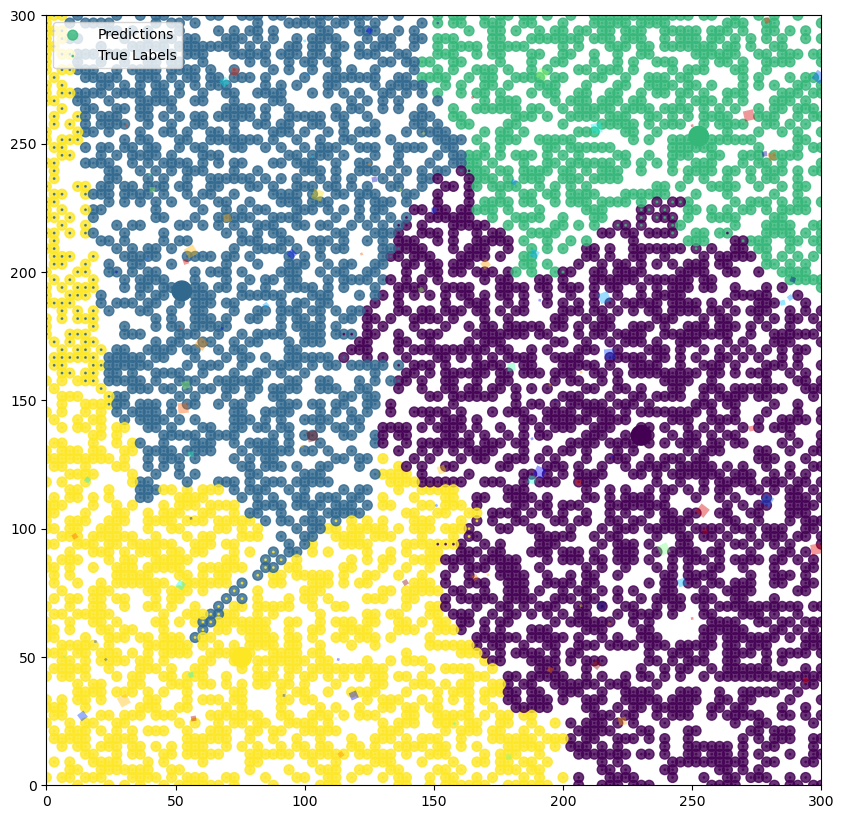

In [21]:
fig = plt.figure(figsize=(10, 10)) # initialize the figure
ax = fig.add_subplot(111) # add subplot
infer_points_plt = infer_points # infer_points
#z = z
classes_ = z # z
ax.scatter(infer_points_plt[:, 0], infer_points_plt[:, 1], c=z, s=50, label='Predictions', alpha=0.8) # plot infer_points
# plot z_i labels
# color
classes_ = z_i # z_i
ax.scatter(infer_points_plt[:, 0], infer_points_plt[:, 1], c=classes_, s=1, label='True Labels', alpha=0.8) # plot infer_points
ax.set_xlim([0, 300])
ax.set_ylim([0, 300])
# plot legend
plt.legend(scatterpoints=1, loc='upper left', fontsize=10)
# also vis data
pt.plot_data_on_manifold(fig, ax, squares, size=10, limits=[0, 300, 0, 300])
# plot best_outputs
plt_bo = teacher.best_outputs.cpu().detach().numpy()
plt_bo = plt_bo
c = np.linspace(0, teacher.best_outputs.shape[0], teacher.best_outputs.shape[0])
ax.scatter(plt_bo[:, 0], plt_bo[:, 1], c=c, s=200)